# Análisis de Datos de Exoplanetas
## Funciones de utilidad y preprocesamiento

In [61]:
import dataio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [62]:


class SkewAwareImputer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.imputers = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # ensure DataFrame for column-wise ops
        self.imputers = {}
        for col in X.columns:
            skew = X[col].dropna().skew()
            if abs(skew) < self.threshold:
                strategy = "mean"
            else:
                strategy = "median"
            imputer = SimpleImputer(strategy=strategy)
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, imputer in self.imputers.items():
            X[col] = imputer.transform(X[[col]])
        return X.values

# --------------------------
# Main preprocessing function
# --------------------------
def build_preprocessing_pipeline(df, nan_col_threshold=0.8):
    """
    Builds preprocessing pipeline:
    - Numeric features: impute and scale
    - Flag features: pass through unchanged (no imputation, no encoding)
    """
    # 1. Drop columns with too many NaNs
    df = df.loc[:, df.isnull().mean() < nan_col_threshold]

    # 2. Separate numeric and flag features
    flag_features = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
    numeric_features = [col for col in df.columns if col not in flag_features]

    # 3. Pipelines
    numeric_pipeline = Pipeline([
        ('imputer', SkewAwareImputer(threshold=1.0)),
        ('scaler', StandardScaler())
    ])

    # Pass through flags unchanged
    from sklearn.preprocessing import FunctionTransformer
    flag_pipeline = FunctionTransformer(lambda x: x)

    # 4. Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('flag', flag_pipeline, flag_features)
        ]
    )

    return preprocessor, numeric_features, flag_features

In [63]:
discards = [
  "kepler_name",
  "kepid",
  "kepoi_name",
  "koi_pdisposition",
  #"koi_disposition",
  "koi_comment",
  "koi_disp_prov",
  "koi_parm_prov",
  "koi_sparprov",
  "koi_vet_date",
  "koi_datalink_dvr",
  "koi_datalink_dvs",
  "koi_quarters",
  "koi_fittype",
  "koi_dikco_msky",
  "koi_dikco_mra",
  "koi_sma",
  "koi_score",
  "koi_max_sngle_ev",
  "koi_hmag",
  "koi_trans_mod",
  "koi_model_dof",
  "koi_delivname",
  "koi_vet_stat",
  "koi_limbdark_mod",
  "koi_sparprov",
  "koi_tce_delivname",
  "koi_time0bk",
  "koi_fwm_sra",
  "koi_fwm_sdec",
  "koi_rmag",
  "koi_kmag",
  "koi_zmag",
  "koi_zmag",
  "koi_ror",
  "koi_jmag",
  "koi_kepmag",
  "koi_kmag",
  "koi_rmag",
  "koi_period",
  "koi_period",
  "koi_period",
  "koi_zmag",
  "koi_rmag",
  "koi_zmag",
  "koi_zmag",
  "koi_kepmag",
  "koi_zmag",
  "koi_ldm_coeff2",
  "koi_jmag",
  "koi_imag",
  "koi_zmag",
  "koi_imag",
  "koi_kepmag",
  "koi_kepmag",
  "koi_rmag",
  "koi_rmag",
  "koi_dikco_mdec"
]

In [64]:
result, status, message = dataio.loadcsvfile("koi_exoplanets.csv")
if(status == 0):
    raise Exception(message)
print(result)

         kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0     10797460  K00752.01  Kepler-227 b  291.93423     0.0  19h27m44.22s   
1     10797460  K00752.02  Kepler-227 c  291.93423     0.0  19h27m44.22s   
2     10811496  K00753.01           NaN  297.00482     0.0  19h48m01.16s   
3     10848459  K00754.01           NaN  285.53461     0.0  19h02m08.31s   
4     10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   
...        ...        ...           ...        ...     ...           ...   
9559  10090151  K07985.01           NaN  297.18875     0.0  19h48m45.30s   
9560  10128825  K07986.01           NaN  286.50937     0.0  19h06m02.25s   
9561  10147276  K07987.01           NaN  294.16489     0.0  19h36m39.57s   
9562  10155286  K07988.01           NaN  296.76288     0.0  19h47m03.09s   
9563  10156110  K07989.01           NaN  297.00977     0.0  19h48m02.34s   

            dec  dec_err       dec_str  koi_gmag  ...  koi_fpflag_co  \
0     48.141651

In [65]:
# ========================================
# FUNCIONES DE CONVERSIÓN Y UTILIDAD
# ========================================

def string_to_ms(texto: str) -> int:
    """
    Convierte un literal de duración como '47d21h15m30.5s' a milisegundos.
    
    Args:
        texto (str): Cadena con formato de duración (ej: '47d21h15m30.5s')
        
    Returns:
        int: Total en milisegundos
        
    Raises:
        ValueError: Si el formato es inválido
    """
    import re
    
    patron = re.compile(
        r'^(?:(?P<d>\d+)d)?'
        r'(?:(?P<h>\d+)h)?'
        r'(?:(?P<m>\d+)m)?'
        r'(?:(?P<s>\d+(?:\.\d+)?)s)?$'
    )
    m = patron.match(texto.strip())
    if not m or not any(m.group(g) for g in ('d','h','m','s')):
        raise ValueError(f"Formato inválido: {texto}")
        
    dias = int(m.group('d')) if m.group('d') else 0
    horas = int(m.group('h')) if m.group('h') else 0
    minutos = int(m.group('m')) if m.group('m') else 0
    segundos = float(m.group('s')) if m.group('s') else 0.0

    total_ms = (
        dias * 86400000 +
        horas * 3600000 +
        minutos * 60000 +
        int(round(segundos * 1000))
    )
    return total_ms

def status_to_int(status: str) -> int:
    """
    Convierte un estado de exoplaneta a un entero.
    
    Args:
        status (str): Estado del exoplaneta
        
    Returns:
        int: 1 para CONFIRMED, 0 para CANDIDATE, -1 para FALSE POSITIVE
        
    Raises:
        ValueError: Si el estado no es válido
    """
    mapping = {
        'CONFIRMED': 1,
        'CANDIDATE': 0,
        'FALSE POSITIVE': -1
    }
    status_upper = status.strip().upper()
    if status_upper not in mapping:
        raise ValueError(f"Estado inválido: {status}")
    return mapping[status_upper]

In [66]:
# ========================================
# FUNCIONES DE LIMPIEZA Y FILTRADO
# ========================================

def get_columns_to_discard():
    """
    Retorna la lista de columnas que deben ser descartadas del análisis.
    
    Returns:
        list: Lista de nombres de columnas a descartar
    """
    return [
        "kepler_name", "kepid", "kepoi_name", "koi_pdisposition",
        "koi_comment", "koi_disp_prov", "koi_parm_prov", "koi_sparprov",
        "koi_vet_date", "koi_datalink_dvr", "koi_datalink_dvs", "koi_quarters",
        "koi_fittype", "koi_dikco_msky", "koi_dikco_mra", "koi_sma",
        "koi_score", "koi_max_sngle_ev", "koi_hmag", "koi_trans_mod",
        "koi_model_dof", "koi_delivname", "koi_vet_stat", "koi_limbdark_mod",
        "koi_tce_delivname", "koi_time0bk", "koi_fwm_sra", "koi_fwm_sdec",
        "koi_rmag", "koi_kmag", "koi_zmag", "koi_ror", "koi_jmag",
        "koi_kepmag", "koi_period", "koi_ldm_coeff2", "koi_imag",
        "koi_dikco_mdec"
    ]

def clean_dataframe(df):
    """
    Limpia el DataFrame eliminando columnas no deseadas y procesando tipos de datos.
    
    Args:
        df (pd.DataFrame): DataFrame original
        
    Returns:
        pd.DataFrame: DataFrame limpio
    """
    # Eliminar columnas especificadas
    discards = get_columns_to_discard()
    cleaned_df = df.drop(columns=discards, errors='ignore')
    
    # Eliminar columnas que terminan en '_str'
    str_columns = [col for col in cleaned_df.columns if col.endswith('_str')]
    cleaned_df = cleaned_df.drop(columns=str_columns)
    
    # Eliminar columnas de error para el análisis de correlación
    error_columns = [col for col in cleaned_df.columns 
                    if col.endswith('_err1') or col.endswith('_err2') or col.endswith('_err')]
    correlation_df = cleaned_df.drop(columns=error_columns)
    
    # Convertir disposición a entero
    if 'koi_disposition' in correlation_df.columns:
        correlation_df['koi_disposition'] = correlation_df['koi_disposition'].apply(status_to_int)
    
    # Eliminar columnas con un solo valor único
    correlation_df = correlation_df.loc[:, correlation_df.nunique() > 1]
    
    # Eliminar columnas completamente vacías
    correlation_df = correlation_df.dropna(axis=1, how='all')
    
    return correlation_df, cleaned_df

def filter_rows_by_missing_data(df, threshold=0.12):
    """
    Filtra filas basándose en el porcentaje de datos faltantes.
    
    Args:
        df (pd.DataFrame): DataFrame a filtrar
        threshold (float): Umbral de datos faltantes permitidos (0-1)
        
    Returns:
        pd.DataFrame: DataFrame filtrado
    """
    print(f"Forma original: {df.shape}")
    filtered_df = df[df.isnull().mean(axis=1) < threshold]
    print(f"Forma después del filtro: {filtered_df.shape}")
    return filtered_df

In [67]:
# ========================================
# FUNCIONES DE ANÁLISIS DE CORRELACIÓN
# ========================================

def analyze_correlation(df, top_n=30, threshold=0.9):
    """
    Analiza la correlación entre variables y encuentra pares altamente correlacionados.
    
    Args:
        df (pd.DataFrame): DataFrame para analizar
        top_n (int): Número de pares más correlacionados a mostrar
        threshold (float): Umbral para considerar alta colinealidad
        
    Returns:
        tuple: (correlation_table, top_n_pairs, high_colinear)
    """
    # Calcular tabla de correlación
    correlation_table = df.corr().abs()
    
    # Crear pares de correlación (evitar duplicados)
    corr_pairs = (
        correlation_table
            .stack()
            .reset_index()
            .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
    )
    corr_pairs = corr_pairs[corr_pairs.var1 < corr_pairs.var2]
    
    # Ordenar de forma descendente
    corr_pairs_sorted = corr_pairs.sort_values('corr', ascending=False)
    
    # Top N pares
    top_n_pairs = corr_pairs_sorted.head(top_n)
    
    # Pares con alta colinealidad
    high_colinear = corr_pairs_sorted[corr_pairs_sorted['corr'] >= threshold]
    
    return correlation_table, top_n_pairs, high_colinear

def print_correlation_analysis(top_n_pairs, high_colinear, top_n=30, threshold=0.9):
    """
    Imprime los resultados del análisis de correlación.
    
    Args:
        top_n_pairs (pd.DataFrame): Top N pares correlacionados
        high_colinear (pd.DataFrame): Pares con alta colinealidad
        top_n (int): Número de pares mostrados
        threshold (float): Umbral de colinealidad
    """
    print(f"Top {top_n} pares de variables correlacionadas (correlación absoluta):")
    print(top_n_pairs.to_string(index=False))
    
    print(f"\nPares con correlación >= {threshold}: (count={len(high_colinear)})")
    print(high_colinear.to_string(index=False))

def plot_correlation_heatmap(correlation_table, figsize=(18, 18)):
    """
    Crea un mapa de calor de la matriz de correlación.
    
    Args:
        correlation_table (pd.DataFrame): Tabla de correlación
        figsize (tuple): Tamaño de la figura
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=figsize)
    plt.matshow(correlation_table, fignum=1)
    plt.colorbar()
    plt.xticks(range(len(correlation_table.columns)), correlation_table.columns, rotation=90)
    plt.yticks(range(len(correlation_table.columns)), correlation_table.columns)
    plt.title("Matriz de Correlación", pad=20)
    plt.show()

In [68]:
# ========================================
# FUNCIONES DE PREPARACIÓN DE DATOS
# ========================================

def separate_confirmed_and_candidates(df):
    """
    Separa los datos en confirmados y candidatos.
    
    Args:
        df (pd.DataFrame): DataFrame con columna 'koi_disposition'
        
    Returns:
        tuple: (clean_df, candidates_df) - confirmados/falsos positivos y candidatos
    """
    clean_df = df[df['koi_disposition'] != 0]  # Confirmados y falsos positivos
    candidates_df = df[df['koi_disposition'] == 0]  # Candidatos
    
    print(f"Datos confirmados/falsos positivos: {clean_df.shape}")
    print(f"Datos candidatos: {candidates_df.shape}")
    
    return clean_df, candidates_df

def prepare_features_and_target(df):
    """
    Separa las características (X) del objetivo (Y).
    
    Args:
        df (pd.DataFrame): DataFrame con todas las variables
        
    Returns:
        tuple: (X, Y) - características y variable objetivo
    """
    Y = df['koi_disposition']
    X = df.drop('koi_disposition', axis=1)
    
    print(f"Características: {X.columns.tolist()}")
    print(f"Forma de X: {X.shape}")
    print(f"Forma de Y: {Y.shape}")
    
    return X, Y

def add_noise_to_features(X, df_with_errors):
    """
    Añade ruido gaussiano a las características basándose en sus errores.
    
    Args:
        X (pd.DataFrame): DataFrame de características
        df_with_errors (pd.DataFrame): DataFrame original con columnas de error
        
    Returns:
        pd.DataFrame: DataFrame con ruido añadido
    """
    import numpy as np
    
    X_noised = X.copy()
    
    for col in X.columns:
        # Buscar columnas de error correspondientes
        if col + "_err1" in df_with_errors.columns:
            sigma = (df_with_errors[col + "_err1"] + df_with_errors[col + "_err2"]) / 2
            X_noised[col] += np.random.normal(0, sigma)
        elif col + "_err" in df_with_errors.columns:
            sigma = df_with_errors[col + "_err"]
            X_noised[col] += np.random.normal(0, sigma)
    
    return X_noised

In [69]:
# ========================================
# FUNCIONES DE BALANCEO DE DATOS
# ========================================

def apply_smote_balancing(X_processed, Y, flag_indices):
    """
    Aplica SMOTENC para balancear los datos, considerando características categóricas.
    
    Args:
        X_processed (np.array): Características procesadas
        Y (pd.Series): Variable objetivo
        flag_indices (list): Índices de las características categóricas
        
    Returns:
        tuple: (X_balanced, y_balanced) - datos balanceados
    """
    from imblearn.over_sampling import SMOTENC
    
    print("Antes de SMOTE: ", X_processed.shape, Y.shape)
    print("Índices de flags para SMOTENC:", flag_indices)
    
    # Usar SMOTENC - flags son categóricas
    smote = SMOTENC(categorical_features=flag_indices, random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_processed, Y)
    
    print("Después de SMOTE:", X_balanced.shape, y_balanced.shape)
    
    return X_balanced, y_balanced

def save_processed_data(X_balanced, y_balanced, feature_names, target_name):
    """
    Guarda los datos procesados en archivos CSV.
    
    Args:
        X_balanced (np.array): Características balanceadas
        y_balanced (np.array): Objetivo balanceado
        feature_names (list): Nombres de las características
        target_name (str): Nombre de la variable objetivo
    """
    import pandas as pd
    
    # Convertir a DataFrames
    X_balanced_df = pd.DataFrame(X_balanced, columns=feature_names)
    Y_balanced_df = pd.DataFrame(y_balanced, columns=[target_name])
    
    # Guardar archivos
    X_balanced_df.to_csv('parameters.csv', index=False)
    Y_balanced_df.to_csv('labels.csv', index=False)
    
    print("Datos guardados en 'parameters.csv' y 'labels.csv'")

In [70]:
# ========================================
# FUNCIONES DE PROCESAMIENTO SEPARADO
# ========================================

def separate_and_save_candidates_vs_others(correlation_df, save_raw=True):
    """
    Separa candidatos del resto de datos y guarda en CSVs separados.
    
    Args:
        correlation_df (pd.DataFrame): DataFrame completo
        save_raw (bool): Si guardar los datos raw separados
        
    Returns:
        tuple: (non_candidates_df, candidates_df)
    """
    import os
    
    # Separar candidatos (0) del resto (-1, 1)
    candidates_df = correlation_df[correlation_df['koi_disposition'] == 0].copy()
    non_candidates_df = correlation_df[correlation_df['koi_disposition'] != 0].copy()
    
    print(f"Candidatos (koi_disposition == 0): {candidates_df.shape}")
    print(f"No candidatos (koi_disposition != 0): {non_candidates_df.shape}")
    
    # Guardar datos raw separados si no existen
    if save_raw:
        candidates_file = 'candidates_raw.csv'
        non_candidates_file = 'non_candidates_raw.csv'
        
        if not os.path.exists(candidates_file):
            candidates_df.to_csv(candidates_file, index=False)
            print(f"Guardado: {candidates_file}")
        else:
            print(f"Archivo {candidates_file} ya existe, se mantiene")
            
        if not os.path.exists(non_candidates_file):
            non_candidates_df.to_csv(non_candidates_file, index=False)
            print(f"Guardado: {non_candidates_file}")
        else:
            print(f"Archivo {non_candidates_file} ya existe, se mantiene")
    
    return non_candidates_df, candidates_df

def process_non_candidates_with_smote(non_candidates_df, df_werror, save_processed=True):
    """
    Procesa solo los datos que NO son candidatos con SMOTENC.
    
    Args:
        non_candidates_df (pd.DataFrame): Datos que no son candidatos
        df_werror (pd.DataFrame): DataFrame con errores para añadir ruido
        save_processed (bool): Si guardar los datos procesados
        
    Returns:
        tuple: (X_balanced, y_balanced, feature_names)
    """
    import os
    import pandas as pd
    
    # Preparar características y objetivo solo para no candidatos
    Y_non_candidates = non_candidates_df['koi_disposition']
    X_non_candidates = non_candidates_df.drop('koi_disposition', axis=1)
    
    print(f"Procesando datos no candidatos: {X_non_candidates.shape}")
    
    # Añadir ruido basado en errores
    X_noised = add_noise_to_features(X_non_candidates, df_werror)
    
    # Preprocesamiento
    preprocessor, num_cols, flag_cols = build_preprocessing_pipeline(X_noised)
    X_processed = preprocessor.fit_transform(X_noised)
    
    # Índices de flags para SMOTENC
    flag_indices = list(range(len(num_cols), len(num_cols) + len(flag_cols)))
    
    # Aplicar SMOTENC solo a datos no candidatos
    X_balanced, y_balanced = apply_smote_balancing(X_processed, Y_non_candidates, flag_indices)
    
    # Nombres de características
    all_cols = num_cols + flag_cols
    
    # Guardar datos procesados si no existen
    if save_processed:
        processed_features_file = 'non_candidates_processed_features.csv'
        processed_labels_file = 'non_candidates_processed_labels.csv'
        
        if not os.path.exists(processed_features_file):
            X_balanced_df = pd.DataFrame(X_balanced, columns=all_cols)
            X_balanced_df.to_csv(processed_features_file, index=False)
            print(f"Guardado: {processed_features_file}")
        else:
            print(f"Archivo {processed_features_file} ya existe, se mantiene")
            
        if not os.path.exists(processed_labels_file):
            y_balanced_df = pd.DataFrame(y_balanced, columns=[Y_non_candidates.name])
            y_balanced_df.to_csv(processed_labels_file, index=False)
            print(f"Guardado: {processed_labels_file}")
        else:
            print(f"Archivo {processed_labels_file} ya existe, se mantiene")
    
    return X_balanced, y_balanced, all_cols

def process_candidates_without_smote(candidates_df, df_werror, save_processed=True):
    """
    Procesa los candidatos sin aplicar SMOTENC (solo preprocesamiento).
    
    Args:
        candidates_df (pd.DataFrame): Datos de candidatos
        df_werror (pd.DataFrame): DataFrame con errores para añadir ruido
        save_processed (bool): Si guardar los datos procesados
        
    Returns:
        tuple: (X_processed, y_candidates, feature_names)
    """
    import os
    import pandas as pd
    
    # Preparar características y objetivo para candidatos
    Y_candidates = candidates_df['koi_disposition']
    X_candidates = candidates_df.drop('koi_disposition', axis=1)
    
    print(f"Procesando candidatos: {X_candidates.shape}")
    
    # Añadir ruido basado en errores
    X_noised = add_noise_to_features(X_candidates, df_werror)
    
    # Preprocesamiento (sin SMOTENC)
    preprocessor, num_cols, flag_cols = build_preprocessing_pipeline(X_noised)
    X_processed = preprocessor.fit_transform(X_noised)
    
    # Nombres de características
    all_cols = num_cols + flag_cols
    
    # Guardar datos procesados si no existen
    if save_processed:
        candidates_features_file = 'candidates_processed_features.csv'
        candidates_labels_file = 'candidates_processed_labels.csv'
        
        if not os.path.exists(candidates_features_file):
            X_processed_df = pd.DataFrame(X_processed, columns=all_cols)
            X_processed_df.to_csv(candidates_features_file, index=False)
            print(f"Guardado: {candidates_features_file}")
        else:
            print(f"Archivo {candidates_features_file} ya existe, se mantiene")
            
        if not os.path.exists(candidates_labels_file):
            y_candidates_df = pd.DataFrame(Y_candidates, columns=[Y_candidates.name])
            y_candidates_df.to_csv(candidates_labels_file, index=False)
            print(f"Guardado: {candidates_labels_file}")
        else:
            print(f"Archivo {candidates_labels_file} ya existe, se mantiene")
    
    return X_processed, Y_candidates.values, all_cols

## Ejecución Principal del Análisis

In [71]:
# Limpieza y preparación inicial de los datos
correlation_df, df_werror = clean_dataframe(result)
print("Matriz de correlación:")
print(correlation_df.corr().abs())

Matriz de correlación:
                        ra       dec  koi_gmag  koi_disposition  koi_count  \
ra                1.000000  0.014373  0.004074         0.152749   0.077302   
dec               0.014373  1.000000  0.011004         0.107198   0.031275   
koi_gmag          0.004074  0.011004  1.000000         0.065988   0.000307   
koi_disposition   0.152749  0.107198  0.065988         1.000000   0.436286   
koi_count         0.077302  0.031275  0.000307         0.436286   1.000000   
koi_num_transits  0.053204  0.036398  0.034049         0.299913   0.169093   
koi_max_mult_ev   0.019563  0.009849  0.144209         0.215579   0.110142   
koi_bin_oedp_sig  0.016874  0.002367  0.020885         0.182187   0.081164   
koi_ldm_coeff1    0.095344  0.022638  0.318167         0.200550   0.105049   
koi_model_snr     0.038810  0.001677  0.127689         0.223792   0.119954   
koi_prad          0.008716  0.003037  0.017383         0.022674   0.013472   
koi_impact        0.022464  0.001804  0.0

In [72]:
# Filtrar filas con muchos datos faltantes
correlation_df = filter_rows_by_missing_data(correlation_df, threshold=0.12)

Forma original: (9564, 38)
Forma después del filtro: (8766, 38)


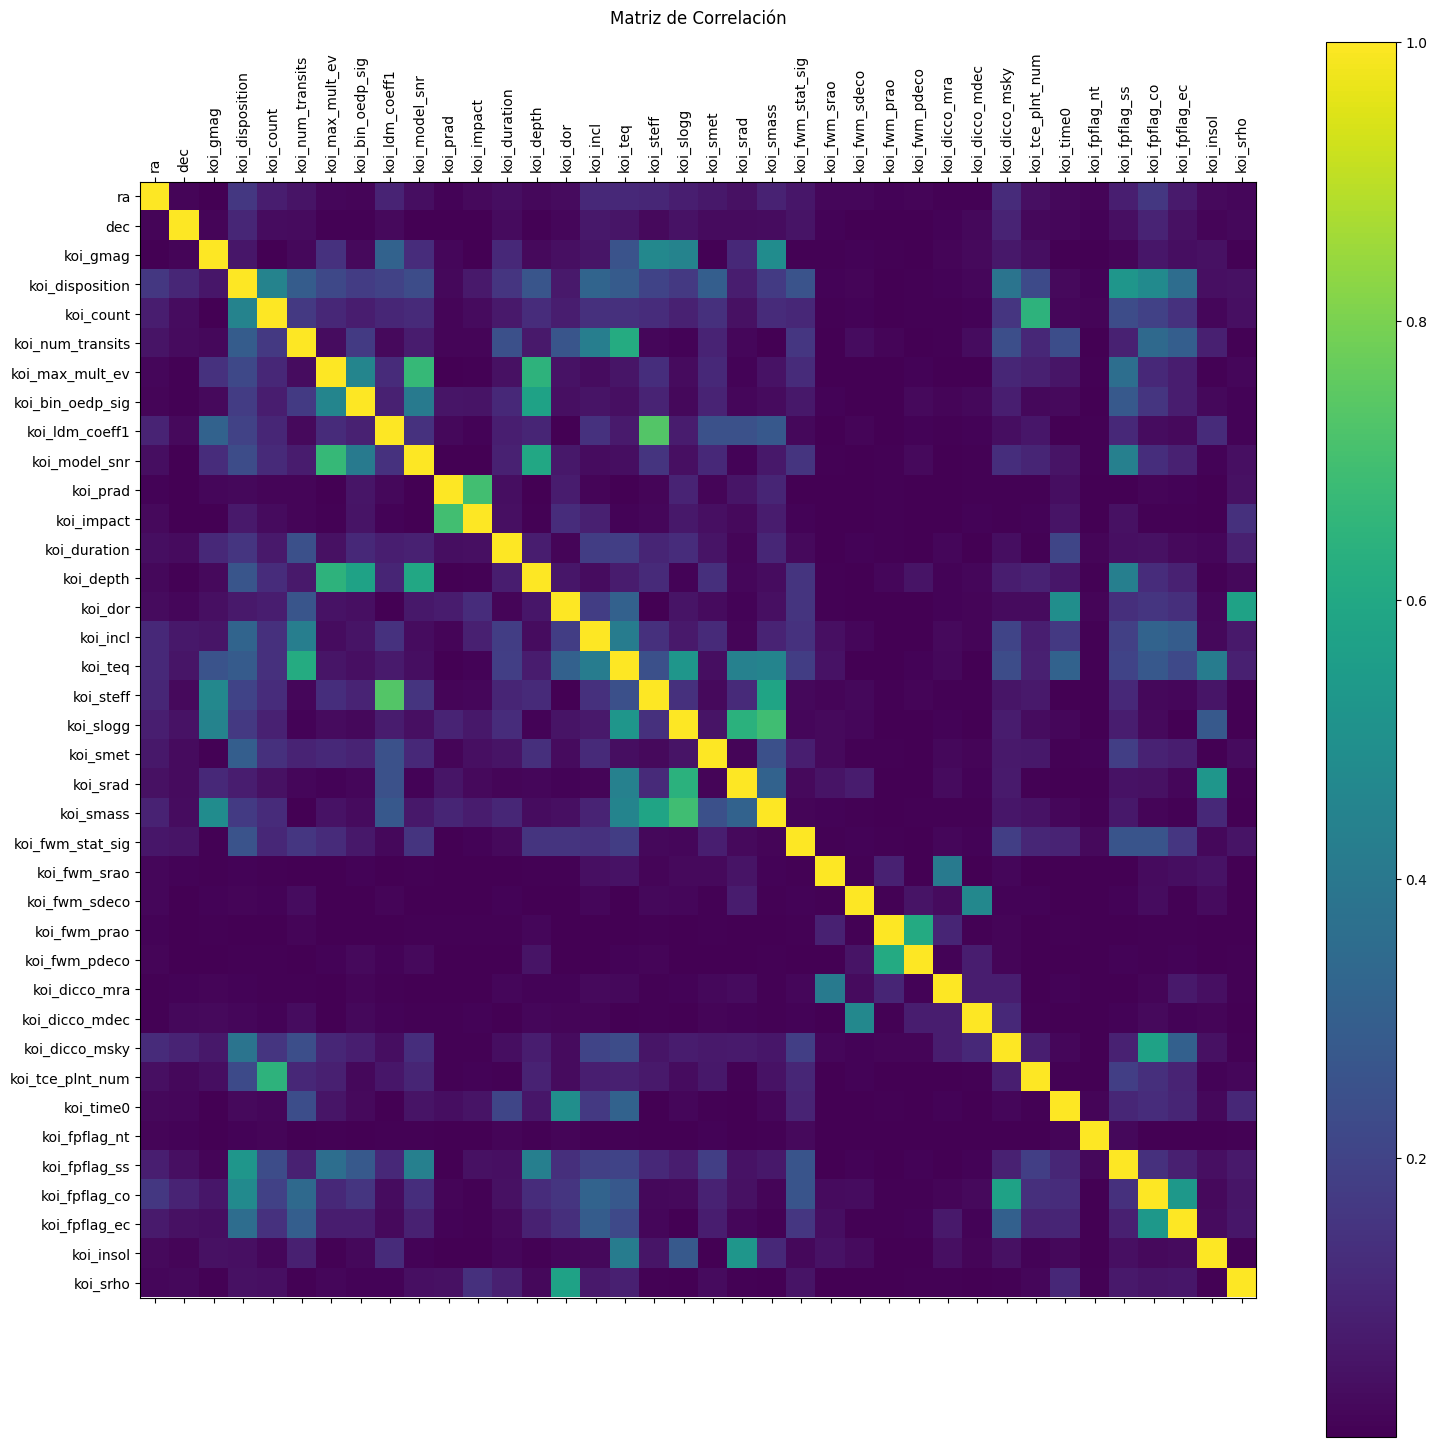

In [73]:
# Análisis de correlación y visualización
correlation_table, top_n_pairs, high_colinear = analyze_correlation(correlation_df, top_n=30, threshold=0.9)

# Mostrar el mapa de calor
plot_correlation_heatmap(correlation_table)

In [74]:
# Mostrar resultados del análisis de correlación
print_correlation_analysis(top_n_pairs, high_colinear, top_n=30, threshold=0.9)

Top 30 pares de variables correlacionadas (correlación absoluta):
            var1             var2     corr
  koi_ldm_coeff1        koi_steff 0.732022
      koi_impact         koi_prad 0.697555
       koi_slogg        koi_smass 0.692316
 koi_max_mult_ev    koi_model_snr 0.671595
       koi_depth  koi_max_mult_ev 0.646398
       koi_count koi_tce_plnt_num 0.645064
       koi_slogg         koi_srad 0.637619
koi_num_transits          koi_teq 0.614891
   koi_fwm_pdeco     koi_fwm_prao 0.612168
       koi_depth    koi_model_snr 0.598454
       koi_smass        koi_steff 0.582852
         koi_dor         koi_srho 0.576026
  koi_dicco_msky    koi_fpflag_co 0.575476
koi_bin_oedp_sig        koi_depth 0.574990
   koi_fpflag_co    koi_fpflag_ec 0.531581
       koi_insol         koi_srad 0.525998
 koi_disposition    koi_fpflag_ss 0.525960
       koi_slogg          koi_teq 0.524920
         koi_dor        koi_time0 0.495066
        koi_gmag        koi_smass 0.484955
 koi_disposition    koi_fpflag_

In [75]:
# Separar datos confirmados y candidatos
clean_df, candidates_df = separate_confirmed_and_candidates(correlation_df)

Datos confirmados/falsos positivos: (6956, 38)
Datos candidatos: (1810, 38)


In [76]:
# Preparar características y variable objetivo
X, Y = prepare_features_and_target(correlation_df)

Características: ['ra', 'dec', 'koi_gmag', 'koi_count', 'koi_num_transits', 'koi_max_mult_ev', 'koi_bin_oedp_sig', 'koi_ldm_coeff1', 'koi_model_snr', 'koi_prad', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_dor', 'koi_incl', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_fwm_stat_sig', 'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco', 'koi_dicco_mra', 'koi_dicco_mdec', 'koi_dicco_msky', 'koi_tce_plnt_num', 'koi_time0', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_insol', 'koi_srho']
Forma de X: (8766, 37)
Forma de Y: (8766,)


In [77]:
print(X)

             ra        dec  koi_gmag  koi_count  koi_num_transits  \
0     291.93423  48.141651    15.890          2             142.0   
1     291.93423  48.141651    15.890          2              25.0   
2     297.00482  48.134129    15.943          1              56.0   
3     285.53461  48.285210    16.100          1             621.0   
4     288.75488  48.226200    16.015          1             515.0   
...         ...        ...       ...        ...               ...   
9559  297.18875  47.093819    14.082          1            2026.0   
9560  286.50937  47.163219    15.189          1             766.0   
9561  294.16489  47.176281    15.853          1            1969.0   
9562  296.76288  47.145142    11.733          1               3.0   
9563  297.00977  47.121021    15.210          1             218.0   

      koi_max_mult_ev  koi_bin_oedp_sig  koi_ldm_coeff1  koi_model_snr  \
0           28.470820            0.6864          0.4603           35.8   
1           20.109507  

In [78]:
def add_noise_to_features(X, df_with_errors):
    """
    Añade ruido gaussiano a las características basándose en sus errores.
    
    Maneja el caso en que X ha sido filtrado (menos filas) y el DataFrame con errores
    aún conserva todas las filas originales, alineando por índice antes de añadir ruido.
    
    Args:
        X (pd.DataFrame): DataFrame de características (posiblemente filtrado)
        df_with_errors (pd.DataFrame): DataFrame original con columnas de error
        
    Returns:
        pd.DataFrame: DataFrame con ruido añadido
    """
    import numpy as np
    
    X_noised = X.copy()
    
    for col in X.columns:
        # Buscar columnas de error correspondientes y alinear índices
        if col + "_err1" in df_with_errors.columns and col + "_err2" in df_with_errors.columns:
            err1 = df_with_errors[col + "_err1"]
            err2 = df_with_errors[col + "_err2"]
            # Alinear y asegurar desviación estándar positiva
            sigma_full = (err1.abs() + err2.abs()) / 2
            sigma = sigma_full.reindex(X.index).fillna(0)
            X_noised[col] += np.random.normal(0, sigma.values)
        elif col + "_err" in df_with_errors.columns:
            sigma_full = df_with_errors[col + "_err"].abs()
            sigma = sigma_full.reindex(X.index).fillna(0)
            X_noised[col] += np.random.normal(0, sigma.values)
        # Si no hay columnas de error, se deja la columna sin modificar
    
    return X_noised

In [79]:
# Añadir ruido a las características basándose en sus errores
X_noised = add_noise_to_features(X, df_werror)

In [80]:
# Data augmentation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
def preprocess_and_balance(X, Y):
    preprocessor, num_cols, bin_cols, cat_cols = build_preprocessing_pipeline(X)

    # Fit and transform
    X_processed = preprocessor.fit_transform(X)

    # Determine categorical column indices for SMOTENC
    feature_names = preprocessor.get_feature_names_out()
    cat_indices = [i for i, name in enumerate(feature_names) 
                   if any(name.startswith(prefix) for prefix in ['bin__', 'cat__'])]

    # Apply SMOTENC
    smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
    X_balanced, y_balanced = smote_nc.fit_resample(X_processed, Y)

    # Convert back to DataFrame
    X_balanced_df = pd.DataFrame(X_balanced, columns=feature_names)
    Y_balanced_df = pd.DataFrame(y_balanced, columns=[Y.name] if hasattr(Y, 'name') else ['target'])

    return X_balanced_df, Y_balanced_df, preprocessor

In [81]:
# ========================================
# PROCESAMIENTO SEPARADO: CANDIDATOS VS NO CANDIDATOS
# ========================================

# 1. Separar y guardar datos raw
non_candidates_df, candidates_df = separate_and_save_candidates_vs_others(correlation_df, save_raw=True)

# 2. Procesar no candidatos con SMOTENC
print("\n=== Procesando datos NO candidatos (con SMOTENC) ===")
X_balanced_non_candidates, y_balanced_non_candidates, feature_names = process_non_candidates_with_smote(
    non_candidates_df, df_werror, save_processed=True
)

# 3. Procesar candidatos sin SMOTENC
print("\n=== Procesando candidatos (sin SMOTENC) ===")
X_processed_candidates, y_candidates, _ = process_candidates_without_smote(
    candidates_df, df_werror, save_processed=True
)

print(f"\nResumen final:")
print(f"No candidatos balanceados: {X_balanced_non_candidates.shape}")
print(f"Candidatos procesados: {X_processed_candidates.shape}")

Candidatos (koi_disposition == 0): (1810, 38)
No candidatos (koi_disposition != 0): (6956, 38)
Guardado: candidates_raw.csv
Guardado: non_candidates_raw.csv

=== Procesando datos NO candidatos (con SMOTENC) ===
Procesando datos no candidatos: (6956, 37)
Guardado: non_candidates_raw.csv

=== Procesando datos NO candidatos (con SMOTENC) ===
Procesando datos no candidatos: (6956, 37)
Antes de SMOTE:  (6956, 37) (6956,)
Índices de flags para SMOTENC: [33, 34, 35, 36]
Antes de SMOTE:  (6956, 37) (6956,)
Índices de flags para SMOTENC: [33, 34, 35, 36]
Después de SMOTE: (8446, 37) (8446,)
Después de SMOTE: (8446, 37) (8446,)
Guardado: non_candidates_processed_features.csv
Guardado: non_candidates_processed_labels.csv

=== Procesando candidatos (sin SMOTENC) ===
Procesando candidatos: (1810, 37)
Guardado: candidates_processed_features.csv
Guardado: candidates_processed_labels.csv

Resumen final:
No candidatos balanceados: (8446, 37)
Candidatos procesados: (1810, 37)
Guardado: non_candidates_pr